1. Import Dependencies and Data

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
for gpu in gpus:
    print(gpu)

In [ ]:
 # Datasets for fashion mnist
 import tensorflow_datasets as tfds
 from matplotlib import pyplot as plt

In [ ]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

2. Build Dataset

In [ ]:
 # Do some data transformation
 import numpy as np

In [ ]:
# setup connection iterator
dataitorator = ds.as_numpy_iterator()

In [ ]:
dataitorator.next()['image'].shape

In [ ]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop and get images
for idx in range(4):
  batch = dataitorator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])


In [ ]:
# Scale images
def scale_images(data):
  image = data['image']
  return image/255

In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through scale_images
ds = ds.map(scale_images)
# Cache the ds for the batch
ds = ds.cache()
# Shuffle
ds = ds.shuffle(60000)
# Batch into 128 images par sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

3. Build Neural Network

3.1 Import Modeling Components

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dense, Flatten, LeakyReLU, Reshape, Dropout

3.2 Build Generator

In [ ]:
def build_generator():
  model = Sequential()
  # Beginnings of a generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop and get images
for idx, im in enumerate(img):
  ax[idx].imshow(np.squeeze(im))
  ax[idx].title.set_text(idx)

3.3 Build Discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  # Convolutional block 1
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Convolutional block 2
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Convolutional block 3
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Convolutional block 4
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

In [ ]:
discriminator.predict(img)

4. Construct Training Loop

4.1 Setup Losses and Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [117]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    #with tf.device('/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    # Create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal(shape=(128,128,1)), training=False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add some noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # Calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

      # Create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Create the true labels
      true_labels = tf.zeros_like(predicted_labels)

      # Calculate loss
      total_g_loss = self.g_loss(true_labels, predicted_labels)

    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [118]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [119]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Build Callback

In [120]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [121]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/GANimages', f'generated_img_{epoch}_{i}.png'))


4.3 Train

In [ ]:
#generator.load_weights(os.path.join('/content/drive/MyDrive/GANmodel', 'generatormodel.h5'))

In [122]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 170ms/step - d_loss: 0.2843 - g_loss: 6.3289
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.3687 - g_loss: 2.9396
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - d_loss: 0.2756 - g_loss: 2.6608
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - d_loss: 0.5836 - g_loss: 1.2024
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 144ms/step - d_loss: 0.6874 - g_loss: 0.5026
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - d_loss: 0.6885 - g_loss: 0.6451
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - d_loss: 0.6976 - g_loss: 0.6504
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 143ms/step - d_loss: 0.6924 - g_loss: 0.6694
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - d_loss: 0.6953 - g_loss: 0.6519
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - d_loss: 0.6949 - g_loss: 0.6608
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - d_loss: 0.6942 - g_loss: 0.6578
Epoch 12/20
469/469

4.4 Review Performance

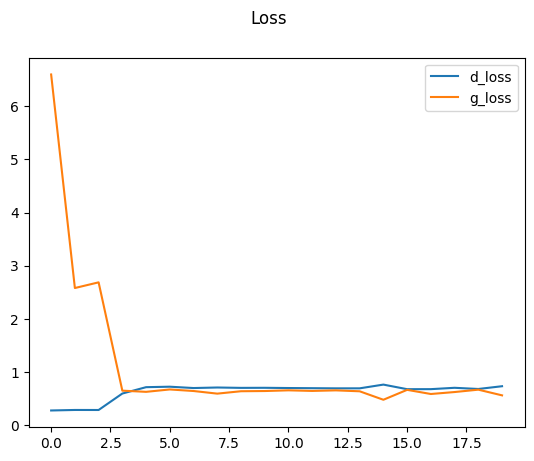

In [123]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

5. Test Out The Generator

5.1 Generate Images

In [128]:
imgs = generator.predict(np.random.randn(16,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


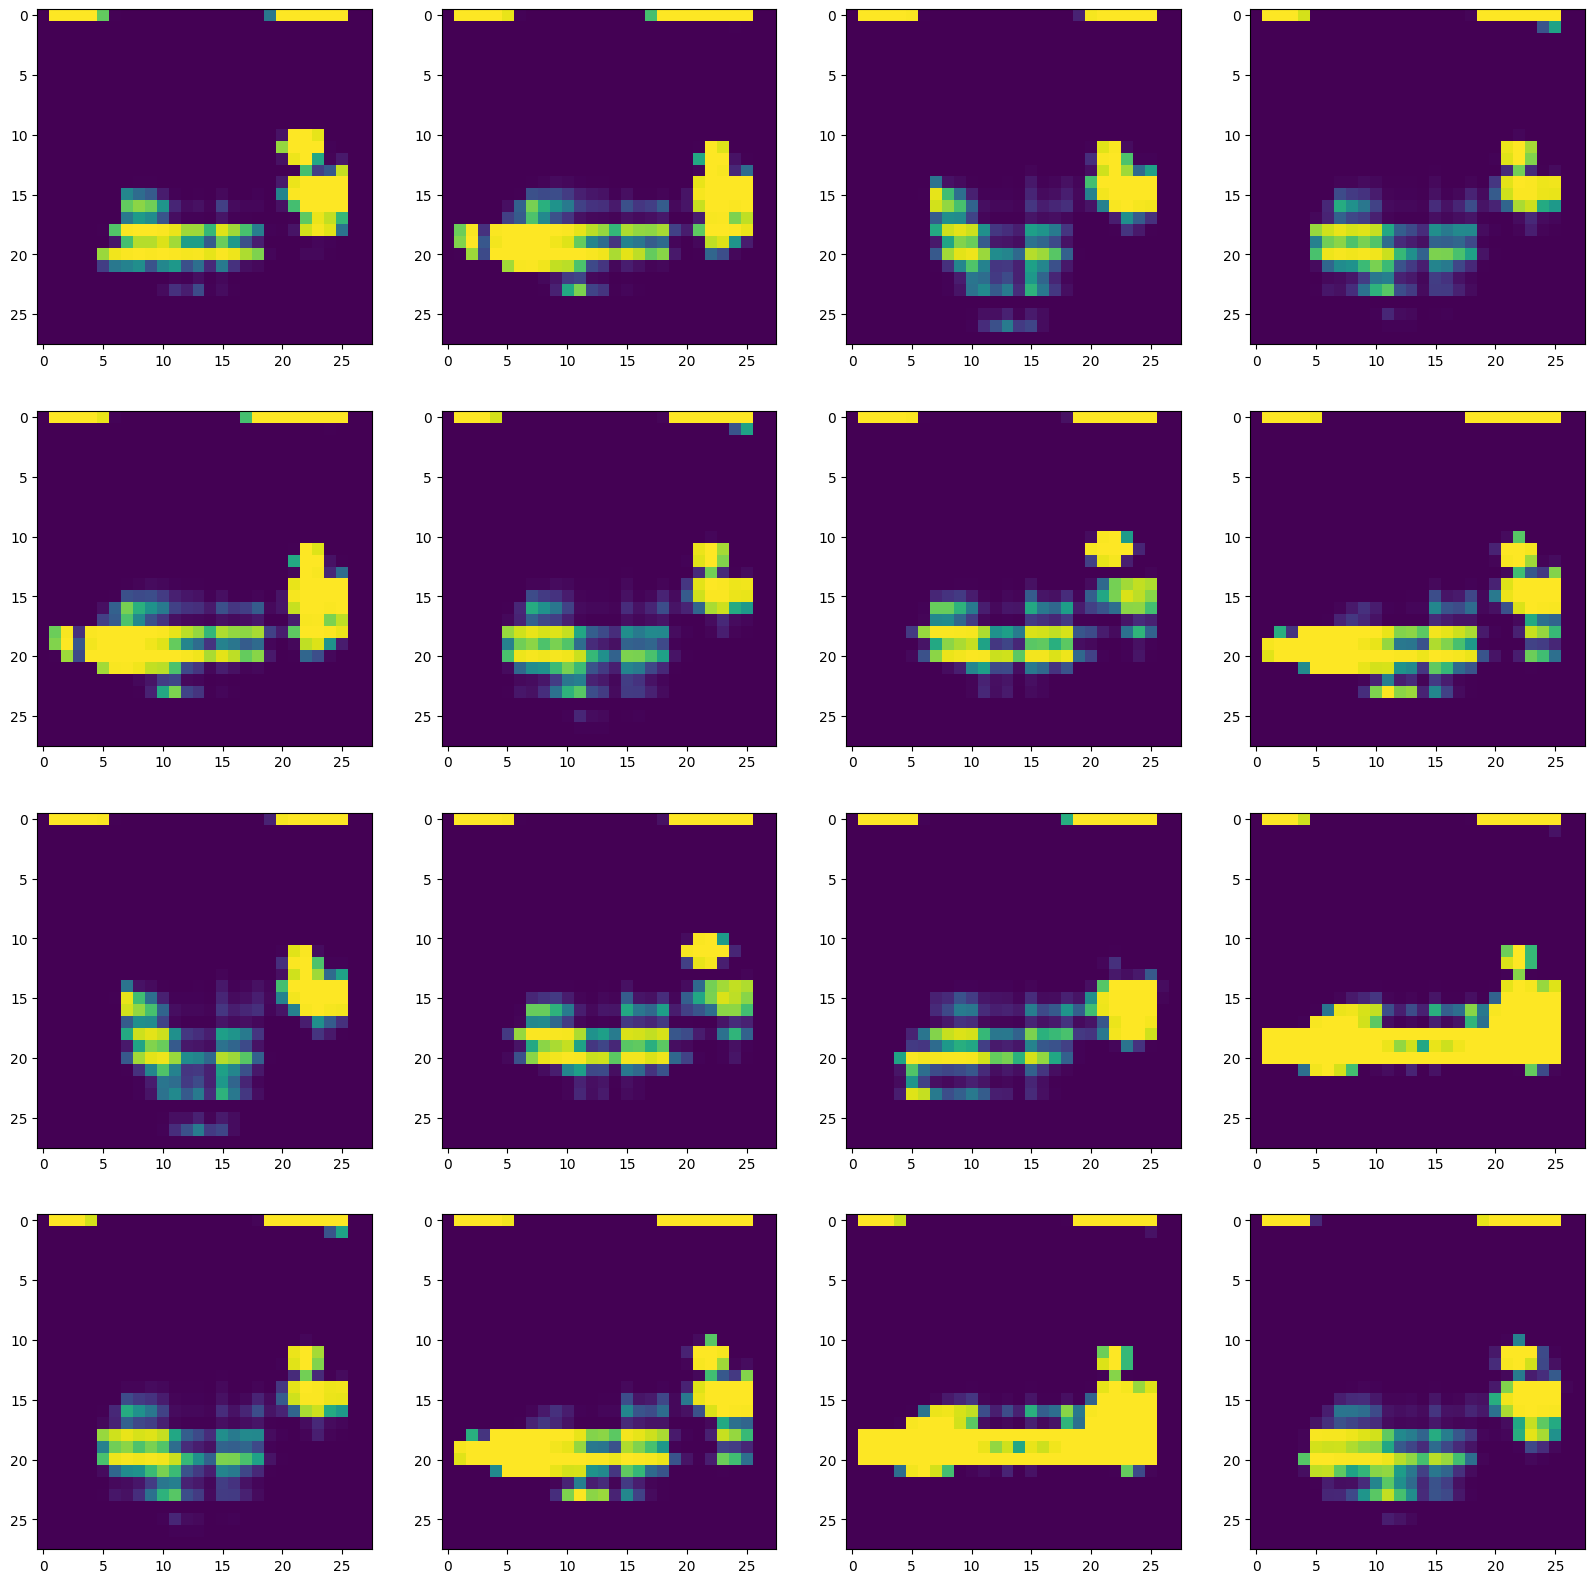

In [125]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
  for c in range(4):
    ax[r, c].imshow(imgs[(r+1)*(c+1)-1])


5.2 Save The Model

In [127]:
generator.save(os.path.join('/content/drive/MyDrive/GANmodel', 'generatormodel.h5'))
discriminator.save(os.path.join('/content/drive/MyDrive/GANmodel', 'discriminatormodel.h5'))